In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [4]:
def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [7]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [59]:
class Encoder(nn.Module):
    def __init__(self, latent_size=16):
        super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(28*28, latent_size)
        self.conv = nn.Conv2d(1, latent_size, 3, stride=1)
    
    def forward(self, x):
        x = torch.sigmoid(self.conv(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=16):
        super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(latent_size, 28*28)
        self.deconv = nn.ConvTranspose2d(latent_size, 1, 3, stride=1)
    
    def forward(self, x):
        x = self.deconv(x)
        x = torch.tanh(x)
        return x

In [60]:
class Net(nn.Module):
    def __init__(self, latent_size=16, loss_fn=F.mse_loss, lr=1e-4, l2=0., simple_rho=False):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.simple_rho = simple_rho
        
    def forward(self, x):
#         x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        if (self.simple_rho):
            dkl = - rho * torch.log(self.data_rho) - (1-rho) * torch.log(1-self.data_rho)
        else:
            dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
            
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
#         target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [61]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [62]:
def train(epoch, models, log=None, noisy=False, zero_half=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        
        train_data = torch.Tensor(np.copy(data))
        if noisy:
            train_data += torch.randn_like(data)           
        if zero_half:
            train_data[:, :, :, :14] = 0                
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(train_data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [63]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [64]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 2.122302 32: 0.346516 64: 2.041005
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.471658 32: 0.116715 64: 0.223545
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.341162 32: 0.069991 64: 0.113178
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.290266 32: 0.051291 64: 0.066726
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.241310 32: 0.043005 64: 0.049709
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.199132 32: 0.038181 64: 0.040255
Test set:
16: loss: 0.1987	rho_loss: 5.7102
32: loss: 0.0384	rho_loss: 4.8270
64: loss: 0.0403	rho_loss: 6.2009

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.198511 32: 0.038706 64: 0.039597
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.162464 32: 0.032352 64: 0.032176
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.143880 32: 0.032818 64: 0.030835
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.120349 32: 0.029888 64: 0.028230
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.105505 32: 0.027529 64: 0.024675
Train

Test set:
16: loss: 0.0111	rho_loss: 0.6960
32: loss: 0.0060	rho_loss: 0.5805
64: loss: 0.0057	rho_loss: 0.7554

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.012007 32: 0.006604 64: 0.006557
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.010850 32: 0.006020 64: 0.005809
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.010116 32: 0.005610 64: 0.005316
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.009675 32: 0.005369 64: 0.004953
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.009994 32: 0.005654 64: 0.005358
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.010259 32: 0.006123 64: 0.005761
Test set:
16: loss: 0.0097	rho_loss: 0.6072
32: loss: 0.0056	rho_loss: 0.5067
64: loss: 0.0053	rho_loss: 0.6679

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.009449 32: 0.005404 64: 0.005029
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.009168 32: 0.005372 64: 0.004971
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.009660 32: 0.005684 64: 0.005498
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [71]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети
# decoded = models['64'].decode(torch.eye(64)) # подаем на вход декодера тестовые данные
# dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход сети на тестовых данных
with torch.no_grad():
    encoded = models['64'].E(data) #подаем данные на кодер
    encoded[encoded < 0.5] = 0. # прореживаем нейроны не преодолевшие порог
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход прореженной сети

исходные данные


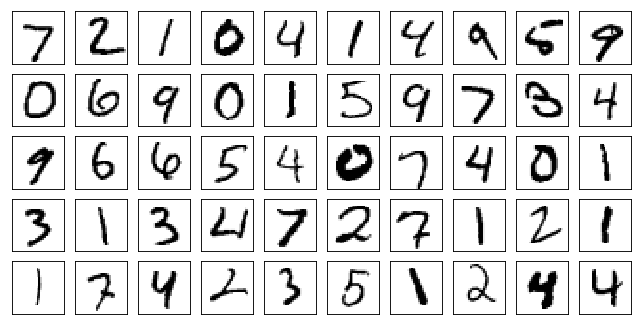

восстановленные данные


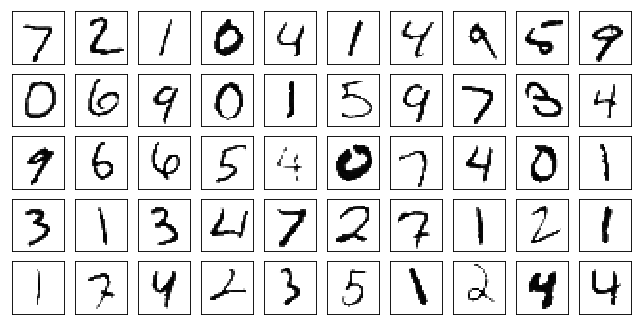

данные на выходе сети с учетом прореживания латентного слоя


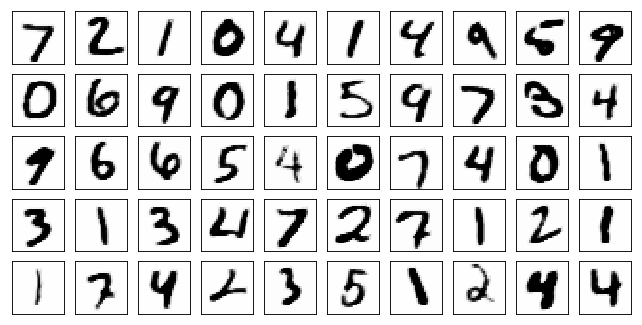

In [70]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))
# print('восстановленные данные с упрощенным rho loss')
# plot_mnist(rho_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя')
plot_mnist(f_to_plot, (5, 10))
# print('данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss')
# plot_mnist(rho_f_to_plot, (5, 10))
# print('данные на выходе сети при подаче на латентный слой тестовых единичных данных')
# plot_mnist(dec_to_plot, (8, 8))
# print('данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss')
# plot_mnist(rho_dec_to_plot, (8, 8))

In [72]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [73]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, noisy=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.450376 32: 1.859513 64: 3.062493
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.345595 32: 0.388984 64: 0.503090
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.211724 32: 0.262250 64: 0.290078
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.160277 32: 0.200998 64: 0.192442
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.125944 32: 0.156497 64: 0.130963
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.112772 32: 0.137777 64: 0.110637
Test set:
16: loss: 0.0642	rho_loss: 5.1976
32: loss: 0.0758	rho_loss: 5.6117
64: loss: 0.0476	rho_loss: 5.9199

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.116656 32: 0.140186 64: 0.111561
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.107740 32: 0.129458 64: 0.103878
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.097117 32: 0.109314 64: 0.089009
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.086510 32: 0.096541 64: 0.079186
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.090253 32: 0.102054 64: 0.084356
Train

Test set:
16: loss: 0.0186	rho_loss: 0.6438
32: loss: 0.0187	rho_loss: 0.7378
64: loss: 0.0176	rho_loss: 0.8291

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.058951 32: 0.058686 64: 0.056141
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.060511 32: 0.060091 64: 0.057961
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.060867 32: 0.060433 64: 0.057861
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.059104 32: 0.058978 64: 0.056758
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.061488 32: 0.061431 64: 0.058927
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.058051 32: 0.058113 64: 0.056127
Test set:
16: loss: 0.0184	rho_loss: 0.5732
32: loss: 0.0184	rho_loss: 0.6628
64: loss: 0.0174	rho_loss: 0.7548

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.056165 32: 0.056362 64: 0.054224
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.060016 32: 0.059907 64: 0.057970
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.062120 32: 0.062271 64: 0.059750
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [74]:
data, _ = next(iter(test_loader))
data += torch.randn_like(data)
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети

исходные данные


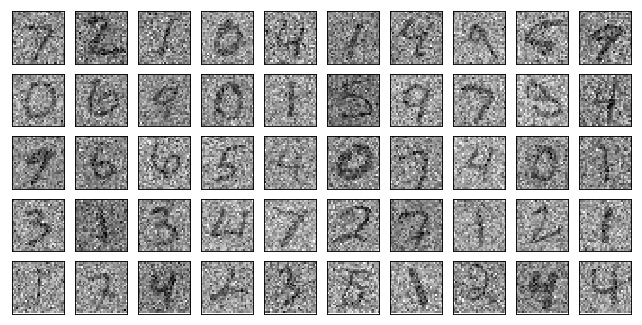

восстановленные данные


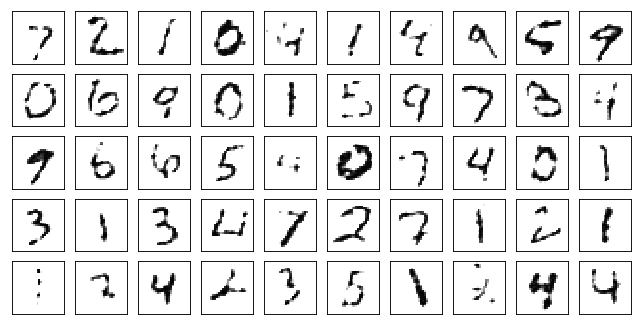

In [75]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))